In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

from libVAE import vae, losses

# Define models and data

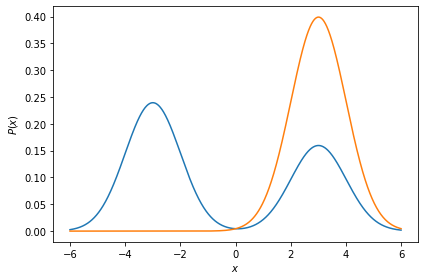

In [2]:
#Create toy distribution to draw from

def create_dist(f):
    #f is the probability to be in lower Gaussian peak
    if isinstance(f, (int, float)) or len(f.shape) == 0:
        ones_batch=1.0
    else:
        f = np.array(f)
        ones_batch = np.ones((f.shape[0],)).astype('float32')
    probs = np.array([f, 1.0-f], dtype='float32').T
    return tfp.distributions.Mixture(cat=tfp.distributions.Categorical(probs=probs),
                                     components=[tfp.distributions.Normal(loc=-3.0*ones_batch, scale=ones_batch),
                                                 tfp.distributions.Normal(loc=3.0*ones_batch, scale=ones_batch)])

mix_dist_bi = create_dist(0.6)
mix_dist_uni = create_dist(0.0)
x_grid = np.arange(-6.0, 6.0, 0.01)

fig, ax = plt.subplots()
ax.plot(x_grid, mix_dist_bi.prob(x_grid))
ax.plot(x_grid, mix_dist_uni.prob(x_grid))
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$P(x)$')
fig.tight_layout()
plt.show()

In [3]:
#Create joint distributions in various ways for 2 DOFs

#First with bimodal distributions
#First, independent
ind_dist_bi = tfp.distributions.JointDistributionSequential([create_dist(0.6),
                                                                        create_dist(0.6)])

#Next with the low/high Gaussians correlated
#So if first DOF is negative (lower peak) then second DOF must also be from lower peak
corr_dist_bi = tfp.distributions.JointDistributionSequential([create_dist(0.6),
                                                                         lambda x1: create_dist(-0.5*(tf.sign(x1)-1))])

#First with unimodal distributions - but here only consider independent
#First, independent
ind_dist_uni = tfp.distributions.JointDistributionSequential([create_dist(1.0),
                                                                         create_dist(1.0)])


In [4]:
#Generate data
#Do in chunks and save
n_chunks = 100
chunk_size = 1000

dat_ind_bi = np.zeros((n_chunks*chunk_size, 2), dtype='float32')
dat_corr_bi = np.zeros((n_chunks*chunk_size, 2), dtype='float32')
dat_ind_uni = np.zeros((n_chunks*chunk_size, 2), dtype='float32')

for i in range(n_chunks):
    this_ind_bi = tf.stack(ind_dist_bi.sample(chunk_size), axis=1).numpy()
    this_corr_bi = tf.stack(corr_dist_bi.sample(chunk_size), axis=1).numpy()
    this_ind_uni = tf.stack(ind_dist_uni.sample(chunk_size), axis=1).numpy()
    
    dat_ind_bi[i*chunk_size:(i+1)*chunk_size, :] = this_ind_bi
    dat_corr_bi[i*chunk_size:(i+1)*chunk_size, :] = this_corr_bi
    dat_ind_uni[i*chunk_size:(i+1)*chunk_size, :] = this_ind_uni

np.save('independent_bimodal', dat_ind_bi)
np.save('correlated_bimodal', dat_corr_bi)
np.save('independent_unimodal', dat_ind_uni)

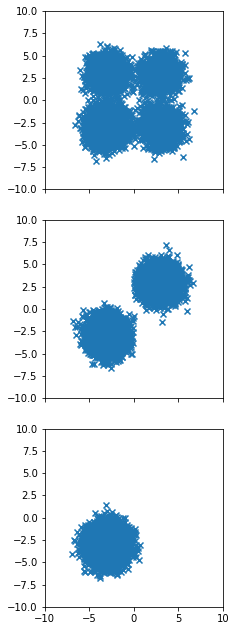

In [5]:
#Plot each distribution in 2D
distFig, distAx = plt.subplots(3, sharex=True, sharey=True, figsize=(3, 9))

distAx[0].scatter(dat_ind_bi[::10, 0], dat_ind_bi[::10, 1], marker='x')
distAx[1].scatter(dat_corr_bi[::10, 0], dat_corr_bi[::10, 1], marker='x')
distAx[2].scatter(dat_ind_uni[::10, 0], dat_ind_uni[::10, 1], marker='x')

distAx[0].set_xlim((-10.0, 10.0))
distAx[0].set_ylim((-10.0, 10.0))
for a in distAx:
    a.set_aspect('equal')

distFig.tight_layout()

plt.show()